In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np

import typing
from typing import Any, Tuple
from pathlib import Path

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

2023-01-30 13:54:08.074941: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-30 13:54:08.756822: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.8/lib64:/usr/local/cuda-11.8/lib64:
2023-01-30 13:54:08.756879: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.8/lib64:/usr/local/cuda-11.8/lib64:
2023-01-30 13:54:08.

In [3]:
class ShapeChecker:
    def __init__(self):
        self.shapes = {}

    def __call__(self, tensor, names, broadcast=False):
        if not tf.executing_eagerly():
            return

        parsed = einops.parse_shape(tensor, names)

        for name, new_dim in parsed.items():
            old_dim = self.shapes.get(name, None)

            if broadcast and new_dim == 1:
                continue

            if old_dim is None:
                self.shapes[name] = new_dim
                continue

            if new_dim != old_dim:
                raise ValueError(
                    f"Shape mismatch for dimension: '{name}'\n"
                    f"  found: {new_dim}\n"
                    f"  expected: {old_dim}"
                )

In [4]:
path_to_file = Path("/home/abhash/Data/NMT_Datasets/spa-eng/spa.txt")

In [5]:
path_to_file.is_file()

True

In [6]:
def load_data(path):
    text = path.read_text(encoding='utf-8')
    lines = text.splitlines()
    pairs = [line.split('\t') for line in lines]

    context = np.array([context1 for target, context1, context2 in pairs])
    target = np.array([target for target, context1, context2 in pairs])

    return target, context

In [7]:
target_raw, context_raw = load_data(path_to_file)
print(context_raw[-1])

Un día, me desperté y vi que Dios me había puesto pelo en la cara. Me lo afeité. Al día siguiente, vi que Dios me lo había vuelto a poner en la cara, así que me lo afeité otra vez. Al tercer día, cuando vi que Dios me había puesto pelo en la cara de nuevo, decidí que Dios se saliera con la suya. Por eso tengo barba.


In [8]:
target_raw.shape, context_raw.shape

((139013,), (139013,))

In [9]:
print(target_raw[-1])

One day, I woke up to find that God had put hair on my face. I shaved it off. The next day, I found that God had put it back on my face, so I shaved it off again. On the third day, when I found that God had put hair back on my face again, I decided to let God have his way. That's why I have a beard.


In [10]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

2023-01-30 13:54:10.108113: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-30 13:54:10.127026: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-30 13:54:10.127227: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-30 13:54:10.127789: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [11]:
len(list(train_raw)), len(list(val_raw))

(1735, 438)

In [12]:
for example_context_strings, example_target_strings in train_raw.take(1):
    print(example_context_strings[:5])
    print()
    print(example_target_strings[:5])
    break

tf.Tensor(
[b'Mi padre va a visitar Australia la semana pr\xc3\xb3xima.'
 b'\xc2\xbfTienes algo que esconder?'
 b'Lo que har\xc3\xa9 ser\xc3\xa1 limpiar la pieza.' b'Coja solo una.'
 b'Caminar a la estaci\xc3\xb3n desde aqu\xc3\xad s\xc3\xb3lo lleva quince minutos.'], shape=(5,), dtype=string)

tf.Tensor(
[b'My father is to visit Australia next week.'
 b'Do you have something to hide?' b"What I'll do is clean the room."
 b'Just take one.'
 b'It only takes about fifteen minutes to walk to the station from here.'], shape=(5,), dtype=string)


In [13]:
isinstance(example_context_strings, tf.Tensor)

True

In [14]:
example_text = tf.constant('¿Todavía está en casa?')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'


In [15]:
def tf_lower_and_split_punct(text):
    # Split accented characters.
    text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    # Keep space, a to z, and select punctuation.
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    # Add spaces around punctuation.
    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
    # Strip whitespace.
    text = tf.strings.strip(text)

    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

In [16]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


In [17]:
isinstance(tf_lower_and_split_punct(example_text), tf.Tensor)

True

In [18]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [19]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'no', 'el', 'tom']

In [20]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'i', 'the', 'to', 'you', 'tom']

In [21]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 24, 134, 116, 10, 897, 379, 11, 179, 846, 4, 3],
 [2, 13, 89, 59, 5, 2199, 12, 3],
 [2, 22, 5, 559, 336, 1152, 11, 939, 4, 3]]>

In [22]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] mi padre va a visitar australia la semana proxima . [END]'

Text(0.5, 1.0, 'Mask')

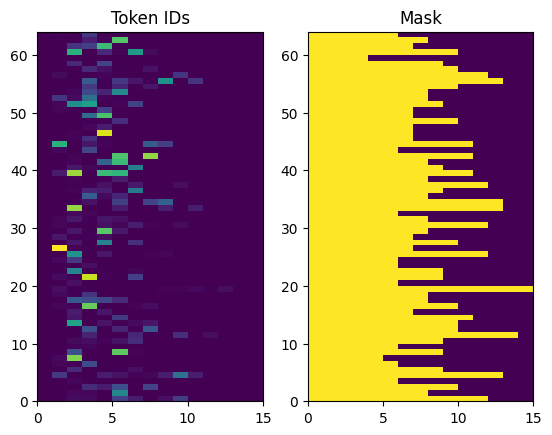

In [23]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

In [24]:
def process_text(context, target):
    context = context_text_processor(context).to_tensor()
    target = target_text_processor(target)
    targ_in = target[:,:-1].to_tensor()
    targ_out = target[:,1:].to_tensor()
    return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [25]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
    print(ex_context_tok[0, :10].numpy()) 
    print()
    print(ex_tar_in[0, :10].numpy()) 
    print(ex_tar_out[0, :10].numpy())

[   2    9    7    1    5   30   69   68 1461    4]

[   2    9   60 1207   33   20   88  491    4    0]
[   9   60 1207   33   20   88  491    4    3    0]


In [26]:
UNITS = 256

In [27]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, text_processor, units):
        super(Encoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.units = units

        # The embedding layer converts tokens to vectors
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.units, mask_zero=True)

        # The RNN layer processes those vectors sequentially.
        self.rnn = tf.keras.layers.Bidirectional(
            merge_mode='sum',
            layer=tf.keras.layers.GRU(
                units, return_sequences=True, recurrent_initializer='glorot_uniform'
            )
        )

    def call(self, x):
        shape_checker = ShapeChecker()
        shape_checker(x, 'batch s')

        x = self.embedding(x)
        shape_checker(x, 'batch s units')

        x = self.rnn(x)
        shape_checker(x, 'batch s units')

        return x

    def convert_input(self, texts):
        texts = tf.convert_to_tensor(texts)
        if len(texts.shape) == 0:
            texts = tf.convert_to_tensor(texts)[tf.newaxis]

        context = self.text_processor(texts).to_tensor()
        context = self(context)
        return context

In [28]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 14)
Encoder output, shape (batch, s, units): (64, 14, 256)


2023-01-30 13:54:19.728367: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700


In [29]:
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__()
        self.last_attention_weights = None
        self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, x, context):
        shape_checker = ShapeChecker()
        shape_checker(x, 'batch t units')
        shape_checker(context, 'batch s units')

        attn_output, attn_scores = self.mha(
            query=x,
            value=context,
            return_attention_scores=True
        )

        shape_checker(x, 'batch t units')
        shape_checker(attn_scores, 'batch heads t s')

        # Cache the attention scores for plotting later
        attn_scores = tf.reduce_mean(attn_scores, axis=1)
        shape_checker(attn_scores, 'batch t s')
        self.last_attention_weights = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

In [30]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 14, 256)
Target sequence, shape (batch, t, units): (64, 15, 256)
Attention result, shape (batch, t, units): (64, 15, 256)
Attention weights, shape (batch, t, s):    (64, 15, 14)


In [31]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1.        , 1.        , 0.9999999 , 0.9999999 , 1.        ,
       0.99999994, 1.        , 1.        , 1.        , 1.0000001 ,
       1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 ],
      dtype=float32)

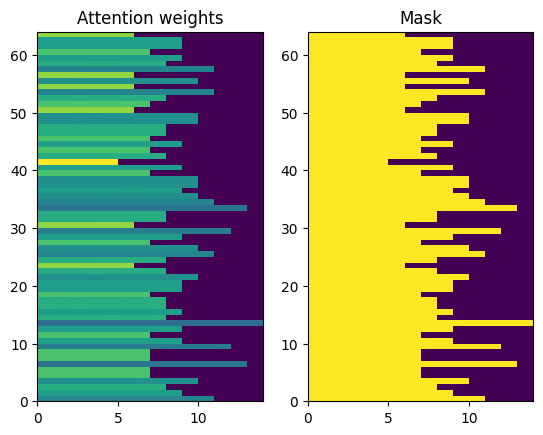

In [32]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');

In [33]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, text_processor, units):
        super(Decoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.word_to_id = tf.keras.layers.StringLookup(
            vocabulary=text_processor.get_vocabulary(),
            mask_token='', oov_token='[UNK]')
        self.id_to_word = tf.keras.layers.StringLookup(
            vocabulary=text_processor.get_vocabulary(),
            mask_token='', oov_token='[UNK]',
            invert=True)
        self.start_token = self.word_to_id('[START]')
        self.end_token = self.word_to_id('[END]')

        self.units = units


        # 1. The embedding layer converts token IDs to vectors
        self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                                   units, mask_zero=True)

        # 2. The RNN keeps track of what's been generated so far.
        self.rnn = tf.keras.layers.GRU(units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

        # 3. The RNN output will be the query for the attention layer.
        self.attention = CrossAttention(units)

        # 4. This fully connected layer produces the logits for each
        # output token.
        self.output_layer = tf.keras.layers.Dense(self.vocab_size)
    
    def call(self,
             context, x,
             state=None,
             return_state=False):  
        shape_checker = ShapeChecker()
        shape_checker(x, 'batch t')
        shape_checker(context, 'batch s units')

        # 1. Lookup the embeddings
        x = self.embedding(x)
        shape_checker(x, 'batch t units')

        # 2. Process the target sequence.
        x, state = self.rnn(x, initial_state=state)
        shape_checker(x, 'batch t units')

        # 3. Use the RNN output as the query for the attention over the context.
        x = self.attention(x, context)
        self.last_attention_weights = self.attention.last_attention_weights
        shape_checker(x, 'batch t units')
        shape_checker(self.last_attention_weights, 'batch t s')

        # Step 4. Generate logit predictions for the next token.
        logits = self.output_layer(x)
        shape_checker(logits, 'batch t target_vocab_size')

        if return_state:
            return logits, state
        else:
            return logits

    def get_initial_state(self, context):
        batch_size = tf.shape(context)[0]
        start_tokens = tf.fill([batch_size, 1], self.start_token)
        done = tf.zeros([batch_size, 1], dtype=tf.bool)
        embedded = self.embedding(start_tokens)
        return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

    def tokens_to_text(self, tokens):
        words = self.id_to_word(tokens)
        result = tf.strings.reduce_join(words, axis=-1, separator=' ')
        result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
        result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
        return result

    def get_next_token(self, context, next_token, done, state, temperature=0.0):
        logits, state = self(
            context, next_token, state=state, return_state=True
        )

        if temperature == 0.0:
            next_token = tf.argmax(logits, axis=-1)
        else:
            logits = logits[:, -1, :] / temperature
            next_token = tf.random.categorical(logits, num_samples=1)

        done = done | (next_token == self.end_token)

        next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

        return next_token, done, state

In [34]:
decoder = Decoder(target_text_processor, UNITS)

In [35]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 14, 256)
input target tokens shape: (batch, t) (64, 15)
logits shape shape: (batch, target_vocabulary_size) (64, 15, 5000)


In [36]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'arm it staring issues regret ocean street both misunderstanding nonsense',
       b'flew overnight attention dreadful pepper interpreter wash trade probably volcano',
       b'mankind tough reliable united ants fifteen taught silently cafe wolves'],
      dtype=object)

In [37]:
class Translator(tf.keras.Model):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, units, context_text_processor, target_text_processor):
        super().__init__()
        self.encoder = Encoder(context_text_processor, units)
        self.decoder = Decoder(target_text_processor, units)

    def call(self, inputs):
        context, x = inputs
        context = self.encoder(context)
        logits = self.decoder(context, x)

        try:
            del logits._keras_mask
        except AttributeError:
            pass

        return logits

In [38]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 14)
Target tokens, shape: (batch, t) (64, 15)
logits, shape: (batch, t, target_vocabulary_size) (64, 15, 5000)


In [39]:
def masked_loss(y_true, y_pred):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none'
    )
    loss = loss_fn(y_true, y_pred)

    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    return tf.reduce_sum(loss) / tf.reduce_sum(mask)


def masked_acc(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match) / tf.reduce_sum(mask)

In [40]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

In [41]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 8.517193, 'expected_acc': 0.0002}

In [42]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 6s 25ms/step - loss: 8.5355 - masked_acc: 1.9206e-04 - masked_loss: 8.5355


{'loss': 8.535473823547363,
 'masked_acc': 0.00019205815624445677,
 'masked_loss': 8.535473823547363}

In [43]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [44]:
history = model.fit(
    train_ds.repeat(), 
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/100


2023-01-30 13:54:34.631874: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT8
    }
  }
}

	while inferring type of node 'cond_43/output/_23'
2023-01-30 13:54:35.086319: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f0c24cae8f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-30 13:54:35.086373: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2023-01-

100/100 [==============================] - 24s 133ms/step - loss: 5.0365 - masked_acc: 0.2614 - masked_loss: 5.0365 - val_loss: 4.0917 - val_masked_acc: 0.3510 - val_masked_loss: 4.0917
Epoch 2/100
100/100 [==============================] - 6s 63ms/step - loss: 3.6699 - masked_acc: 0.4037 - masked_loss: 3.6699 - val_loss: 3.3089 - val_masked_acc: 0.4506 - val_masked_loss: 3.3089
Epoch 3/100
100/100 [==============================] - 5s 52ms/step - loss: 3.0771 - masked_acc: 0.4864 - masked_loss: 3.0771 - val_loss: 2.8355 - val_masked_acc: 0.5243 - val_masked_loss: 2.8355
Epoch 4/100
100/100 [==============================] - 4s 45ms/step - loss: 2.6952 - masked_acc: 0.5399 - masked_loss: 2.6952 - val_loss: 2.5283 - val_masked_acc: 0.5580 - val_masked_loss: 2.5283
Epoch 5/100
100/100 [==============================] - 4s 45ms/step - loss: 2.4135 - masked_acc: 0.5798 - masked_loss: 2.4135 - val_loss: 2.2384 - val_masked_acc: 0.6045 - val_masked_loss: 2.2384
Epoch 6/100
100/100 [=========

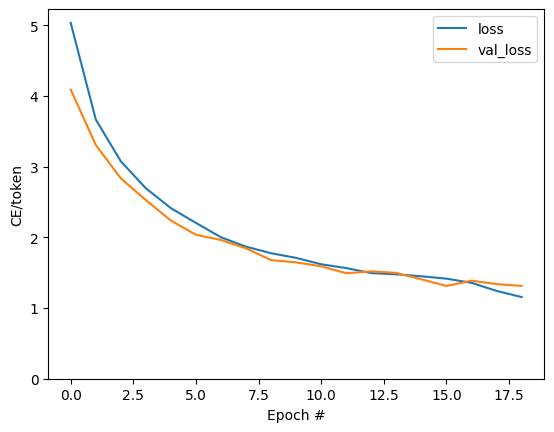

In [45]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

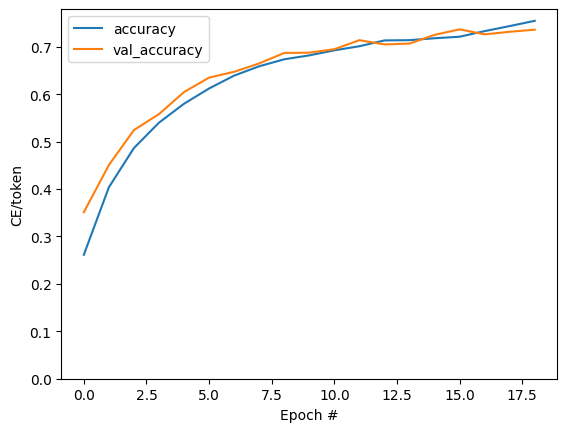

In [46]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [47]:
@Translator.add_method
def translate(self,
              texts,
              *,
              max_length=500,
              temperature=tf.constant(0.0)):
    shape_checker = ShapeChecker()
    context = self.encoder.convert_input(texts)
    batch_size = tf.shape(context)[0]
    shape_checker(context, 'batch s units')

    next_token, done, state = self.decoder.get_initial_state(context)

    # initialize the accumulator
    tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)

    for t in tf.range(max_length):
        # Generate the next token
        next_token, done, state = self.decoder.get_next_token(
            context, next_token, done, state, temperature)
        shape_checker(next_token, 'batch t1')

        # Collect the generated tokens
        tokens = tokens.write(t, next_token)

        # if all the sequences are done, break
        if tf.reduce_all(done):
            break

    # Convert the list of generated token ids to a list of strings.
    tokens = tokens.stack()
    shape_checker(tokens, 't batch t1')
    tokens = einops.rearrange(tokens, 't batch 1 -> batch t')
    shape_checker(tokens, 'batch t')

    text = self.decoder.tokens_to_text(tokens)
    shape_checker(text, 'batch')

    return text


In [48]:
result = model.translate(['¿Todavía está en casa?']) # Are you still home
result[0].numpy().decode()

'are you still at home ? '

In [49]:
@Translator.add_method
def plot_attention(self, text, **kwargs):
    assert isinstance(text, str)
    output = self.translate([text], **kwargs)
    output = output[0].numpy().decode()

    attention = self.last_attention_weights[0]

    context = tf_lower_and_split_punct(text)
    context = context.numpy().decode().split()

    output = tf_lower_and_split_punct(output)
    output = output.numpy().decode().split()[1:]

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)

    ax.matshow(attention, cmap='viridis', vmin=0.0)

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + output, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    ax.set_xlabel('Input text')
    ax.set_ylabel('Output text')


In [50]:
model.plot_attention('¿Todavía está en casa?') # Are you still home

AttributeError: 'Translator' object has no attribute 'last_attention_weights'

In [ ]:
%%time
# This is my life.
model.plot_attention('Esta es mi vida.')

In [ ]:
long_text = context_raw[-1]
model.plot_attention(long_text)

In [ ]:
inputs = [
    'Hace mucho frio aqui.', # "It's really cold here."
    'Esta es mi vida.', # "This is my life."
    'Su cuarto es un desastre.' # "His room is a mess"
]


In [ ]:
class Export(tf.Module):
    def __init__(self, model):
        self.model = model

    @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
    def translate(self, inputs):
        return self.model.translate(inputs)


In [ ]:
export = Export(model)

In [ ]:
%%time
tf.saved_model.save(export, './trained_models/translator',
                    signatures={'serving_default': export.translate})

In [ ]:
%%time
reloaded = tf.saved_model.load('translator')

In [ ]:
%%time
result = reloaded.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()
